# **Homework 8 - Anomaly Detection**

If there are any questions, please contact mlta-2022spring-ta@googlegroups.com

Slide:    [Link]()　Kaggle: [Link](https://www.kaggle.com/c/ml2022spring-hw8)

# Set up the environment


## Package installation

In [1]:
# Training progress bar
# !pip install -q qqdm

## Downloading data

In [2]:
# !wget https://github.com/MachineLearningHW/HW8_Dataset/releases/download/v1.0.0/data.zip

In [3]:
# !unzip data.zip

# Import packages

In [4]:
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch.optim import Adam, AdamW
from qqdm import qqdm, format_str
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


# Loading data

In [5]:

train = np.load('data/trainingset.npy', allow_pickle=True)
test = np.load('data/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(100000, 64, 64, 3)
(19636, 64, 64, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [6]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(48763)

# Autoencoder

# Models & loss

In [7]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # nn.Linear(64 * 64 * 3, 128),
            # nn.ReLU(),
            # nn.Linear(128, 64),
            # nn.ReLU(), 
            # nn.Linear(64, 12), 
            # nn.ReLU(), 
            # nn.Linear(12, 3)
            nn.Linear(64 * 64 * 3, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
        )
        
        self.decoder = nn.Sequential(
            # nn.Linear(3, 12),
            # nn.ReLU(), 
            # nn.Linear(12, 64),
            # nn.ReLU(),
            # nn.Linear(64, 128),
            # nn.ReLU(), 
            # nn.Linear(128, 64 * 64 * 3), 
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 64 * 64 * 3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),        
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),         
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),    
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), 
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD

# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [8]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),
        ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

# Training

## Configuration


In [9]:
# Training hyperparameters
num_epochs = 50
batch_size = 128 # 2000
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Model
model_type = 'fcn' # 'vae'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = {'fcn': fcn_autoencoder(), 'cnn': conv_autoencoder(), 'vae': VAE()}
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training loop

In [10]:

best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    tot_loss = list()
    for data in train_dataloader:

        # ===================loading=====================
        img = data.float().cuda()
        if model_type in ['fcn']:
            img = img.view(img.shape[0], -1)

        # ===================forward=====================
        output = model(img)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
        'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
        'loss': f'{mean_loss:.4f}',
    })
    # ===================save_last========================
    torch.save(model, 'last_model_{}.pt'.format(model_type))




 Iters    Elapsed Time      Speed                                               
 0/50           -             -                                                 
Description   0.0% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 1/50   00:00:17<00:13:56  0.06it/s  1/50   0.0870                              
Description   2.0% |█                                                          | Iters    Elapsed Time      Speed    epoch   loss                               
 2/50   00:00:32<00:13:01  0.06it/s  2/50   0.0573                              
Description   4.0% |██                                                         | Iters    Elapsed Time      Speed    epoch   loss                               
 3/50   00:00:48<00:12:33  0.06it/s  3/50   0.0510                              
Description   6.0% |███                                                        | Iters    Elapsed Time      Spee

In [11]:
# load trained model
checkpoint_path = f'best_model_{model_type}.pt'
model = torch.load(checkpoint_path)
model.eval()

imgs = train_dataset[0:5].cuda()
if model_type in ["fcn"]:
    recon_imgs = model(imgs.reshape(imgs.shape[0], -1)).reshape(imgs.shape)
else:
    recon_imgs = model(imgs)
if model_type in ["vae"]:
    recon_imgs = recon_imgs[0]

imgs = imgs.permute(0, 2, 3, 1)
recon_imgs = recon_imgs.permute(0, 2, 3, 1)

imgs = imgs.reshape(-1, imgs.shape[2], imgs.shape[3])
recon_imgs = recon_imgs.reshape(-1, recon_imgs.shape[2], recon_imgs.shape[3])

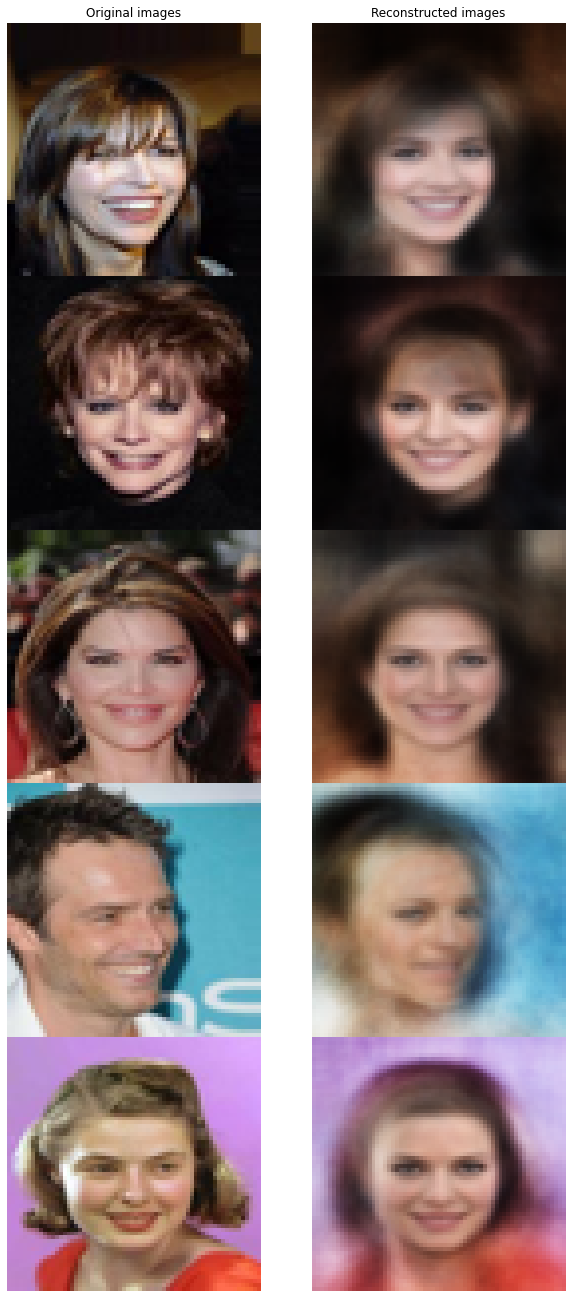

In [12]:
plt.figure(figsize=(2*5, 5*5))

ax = plt.subplot(1, 2, 1)
ax.imshow((imgs.detach().cpu().numpy() + 1.) / 2.)
ax.set_title("Original images")
ax.axis("off")

ax = plt.subplot(1, 2, 2)
ax.imshow((recon_imgs.detach().cpu().numpy() + 1.) / 2.)
ax.set_title("Reconstructed images")
ax.axis("off")

plt.show()

# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [13]:
eval_batch_size = 200

# build testing dataloader
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size)
eval_loss = nn.MSELoss(reduction='none')

# load trained model
checkpoint_path = f'best_model_{model_type}.pt'
model = torch.load(checkpoint_path)
model.eval()

# prediction file 
out_file = 'prediction.csv'

In [14]:
anomality = list()
with torch.no_grad():
  for i, data in enumerate(test_dataloader):
    img = data.float().cuda()
    if model_type in ['fcn']:
      img = img.view(img.shape[0], -1)
    output = model(img)
    if model_type in ['vae']:
      output = output[0]
    if model_type in ['fcn']:
        loss = eval_loss(output, img).sum(-1)
    else:
        loss = eval_loss(output, img).sum([1, 2, 3])
    anomality.append(loss)
anomality = torch.cat(anomality, axis=0)
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()

df = pd.DataFrame(anomality, columns=['score'])
df.to_csv(out_file, index_label = 'ID')